# Forecasting with SARIMAX

In [1]:
# Standard Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [2]:
# Algorithmic Imports
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from pmdarima import auto_arima # for determining ARIMA orders

In [3]:
#Using data aggregated in another .ipynb
df = pd.read_csv('records-MASTER.csv')
df.set_index('DATE',drop=True,inplace=True)
df.index = pd.to_datetime(df.index,dayfirst=True)
df = df.resample(rule='D').mean()

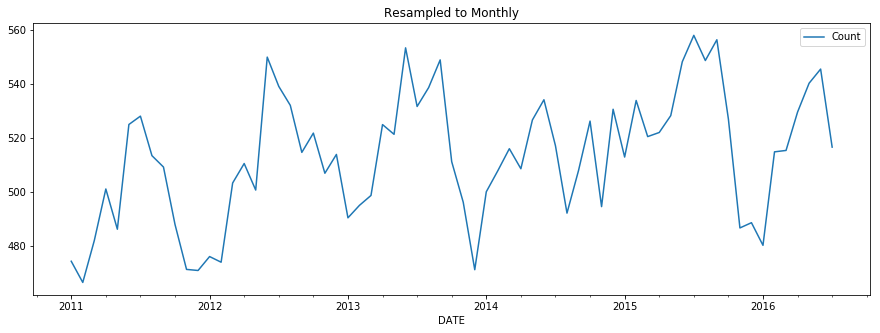

In [4]:
dfW = df.resample(rule='M').mean()
dfW.plot(figsize=(15,5),title='Resampled to Monthly')

In [5]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [6]:
#help(auto_arima)

In [7]:
auto_arima(dfW['Count'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   67
Model:             SARIMAX(1, 1, 1)x(2, 0, 0, 12)   Log Likelihood                -274.766
Date:                            Sun, 11 Aug 2019   AIC                            561.532
Time:                                    09:44:40   BIC                            574.670
Sample:                                         0   HQIC                           566.724
                                             - 67                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0976      0.103      0.950      0.342      -0.104       0.299
ar.L1          0.5530      0.167      3.313      0.001       0.226       0.880
ma.L1         -0.9999     12.870     -0.078      0.938     -26.224      24.225
ar.S.L12       0.1664      0.109      1.522      0.128      -0.048       0.381
ar.S.L24       0.5135      0.164      3.132      0.002       0.192       0.835
sigma2       206.6745   2653.831      0.078      0.938   -4994.739    5408.088
===================================================================================
Ljung-Box (Q):                       24.21   Jarque-Bera (JB):                 0.50
Prob(Q):                              0.98   Prob(JB):                         0.78
Heteroskedasticity (H):               1.27   Skew:                            -0.12
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Train Test Split

In [8]:
len(dfW)

67

In [9]:
# Set one year for testing
train = dfW.iloc[:60]
test = dfW.iloc[60:]

In [10]:
#Fit a SARIMAX(1, 1, 1)x(2, 0, 0, 12) Model
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train['Count'],order=(1,1,1),seasonal_order=(2,0,0,12))
results = model.fit()

In [11]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Count   No. Observations:                   60
Model:             SARIMAX(1, 1, 1)x(2, 0, 0, 12)   Log Likelihood                -246.954
Date:                            Sun, 11 Aug 2019   AIC                            503.908
Time:                                    09:44:40   BIC                            514.296
Sample:                                01-31-2011   HQIC                           507.963
                                     - 12-31-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5470      0.162      3.384      0.001       0.230       0.864
ma.L1         -0.9480      0.042    -22.443      0.000      -1.031      -0.865
ar.S.L12       0.1573      0.120      1.308      0.191      -0.078       0.393
ar.S.L24       0.5357      0.174      3.074      0.002       0.194       0.877
sigma2       212.6613     54.291      3.917      0.000     106.253     319.070
===================================================================================
Ljung-Box (Q):                       22.72   Jarque-Bera (JB):                 0.33
Prob(Q):                              0.99   Prob(JB):                         0.85
Heteroskedasticity (H):               1.48   Skew:                            -0.07
Prob(H) (two-sided):                  0.39   Kurtosis:                         2.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,1,1)(2,0,0,12) Predictions')

In [13]:
predictions

2016-01-31    506.813636
2016-02-29    517.273285
2016-03-31    521.176211
2016-04-30    518.327221
2016-05-31    529.483201
2016-06-30    536.901080
2016-07-31    529.459105
Freq: M, Name: SARIMA(1,1,1)(2,0,0,12) Predictions, dtype: float64

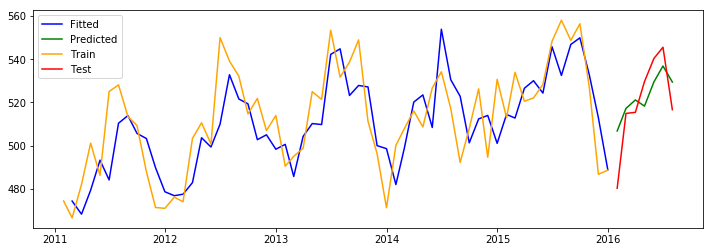

In [14]:
# Plot predictions vs actuals
plt.figure(figsize=(12,4))
plt.plot(results.fittedvalues['2011-02-28':],color='blue',label='Fitted')
plt.plot(predictions,color='green',label='Predicted')
plt.plot(train,color='orange',label='Train')
plt.plot(test,color='red',label='Test')
plt.legend()

In [15]:
from sklearn.metrics import mean_squared_error

#Mean Squared Error
error = mean_squared_error(test['Count'], predictions)
print(f'SARIMA(1,1,1)(2,0,0,12) MSE Error: {round(error,4)}')

SARIMA(1,1,1)(2,0,0,12) MSE Error: 175.3659


In [16]:
from statsmodels.tools.eval_measures import rmse

#Root Mean Squared Error
error = rmse(test['Count'], predictions)
print(f'SARIMA(1,1,1)(2,0,0,12) RMSE Error: {round(error,4)}')

SARIMA(1,1,1)(2,0,0,12) RMSE Error: 13.2426


 *"A forecast method that minimises the MAE will lead to forecasts of the median, while minimising the RMSE will lead to forecasts of the mean"* [Hyndman](https://otexts.com/fpp2/accuracy.html)

**The visual indicates that the forecast is pretty decent by using SARIMA(1,1,1)(2,0,0,12). It'll be worth it to create a backtesting program (Expanding Window Method) to evaluate its vertical effectiveness. Then, horizontal effectiveness can be done where non-ARIMA models are evaluated.**

In [17]:
# First code it in script or def mode -> then OOP

https://eng.uber.com/omphalos/

https://medium.com/cindicator/backtesting-time-series-models-weekend-of-a-data-scientist-92079cc2c540

https://eng.uber.com/forecasting-introduction/